In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

import tensorflow_datasets.public_api as tfds
import tensorflow_hub as hub

import tf_keras as keras

from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras import utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

dataset = tfds.load('oxford_iiit_pet')

2024-05-12 09:34:20.291441: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-12 09:34:20.291551: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-12 09:34:20.393026: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteZLSJ8E/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteZLSJ8E/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [3]:
IMG_SIZE = (224, 224)
SCALE = 1./255
BUTCH_SIZE = 32
EPOCHS = 3
STEPS_PER_EPOCH = 180
efficientnetv2_s = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/classification/2'

1. При анализе данных было выявлено, что размер изображений разный. 
   Многие модели требуют одинаковый размер входных данных, чтобы модель могла правильно их  обрабатывать.
2. Схожесть пород. Некоторые породы схожи между собой, что может вызывать неправильное распознавание питомца.
3. Неправильная разметка. В некоторых классах встречаются породы, принадлежащие другим классам.

# Разделение датасета на тренировочный и тестовый. Предобработка данных.

1. Нормализация. Приводим значения пикселей изображений с диапазона [0; 255] к диапазону [0; 1]
2. Приводим изображения к одному размеру.

Нормализация данных гаранитрует, что модель получает однотипные входные данные, что упрощает обучение и повышает ее точность.
Приведение данных в разных единицах измерения и диапазонах значений к единому виду позволяет сравнивать их между собой или использовать для расчёта схожести объектов. 
Модель эффективнее извлекает признаки и быстрее обучается.

In [6]:
train_dataset = dataset['train']
test_dataset = dataset['test']

train_ds = tfds.as_numpy(train_dataset)
test_ds = tfds.as_numpy(test_dataset)

train_gen = ImageDataGenerator(rescale=SCALE)
test_gen = ImageDataGenerator(rescale=SCALE)

x_train = []
y_train = []
for example in train_ds:
    image_resized = tf.image.resize_with_pad(example['image'], *IMG_SIZE).numpy().astype("uint8")
    x_train.append(image_resized)
    y_train.append(example['label'])

x_train = np.array(x_train)
y_train = np.array(y_train)

train_data = train_gen.flow(x=x_train, 
                            y=y_train,
                            batch_size=BUTCH_SIZE,
                            shuffle=False
                            )


x_test = []
y_test = []
for example in test_ds:
    image_resized = tf.image.resize_with_pad(example['image'], *IMG_SIZE).numpy().astype("uint8")
    x_test.append(image_resized)  
    y_test.append(example['label'])

x_test = np.array(x_test)
y_test = np.array(y_test)

test_data = test_gen.flow(x=x_test,
                        y=y_test,
                        batch_size=BUTCH_SIZE,
                        shuffle=False
                       )

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


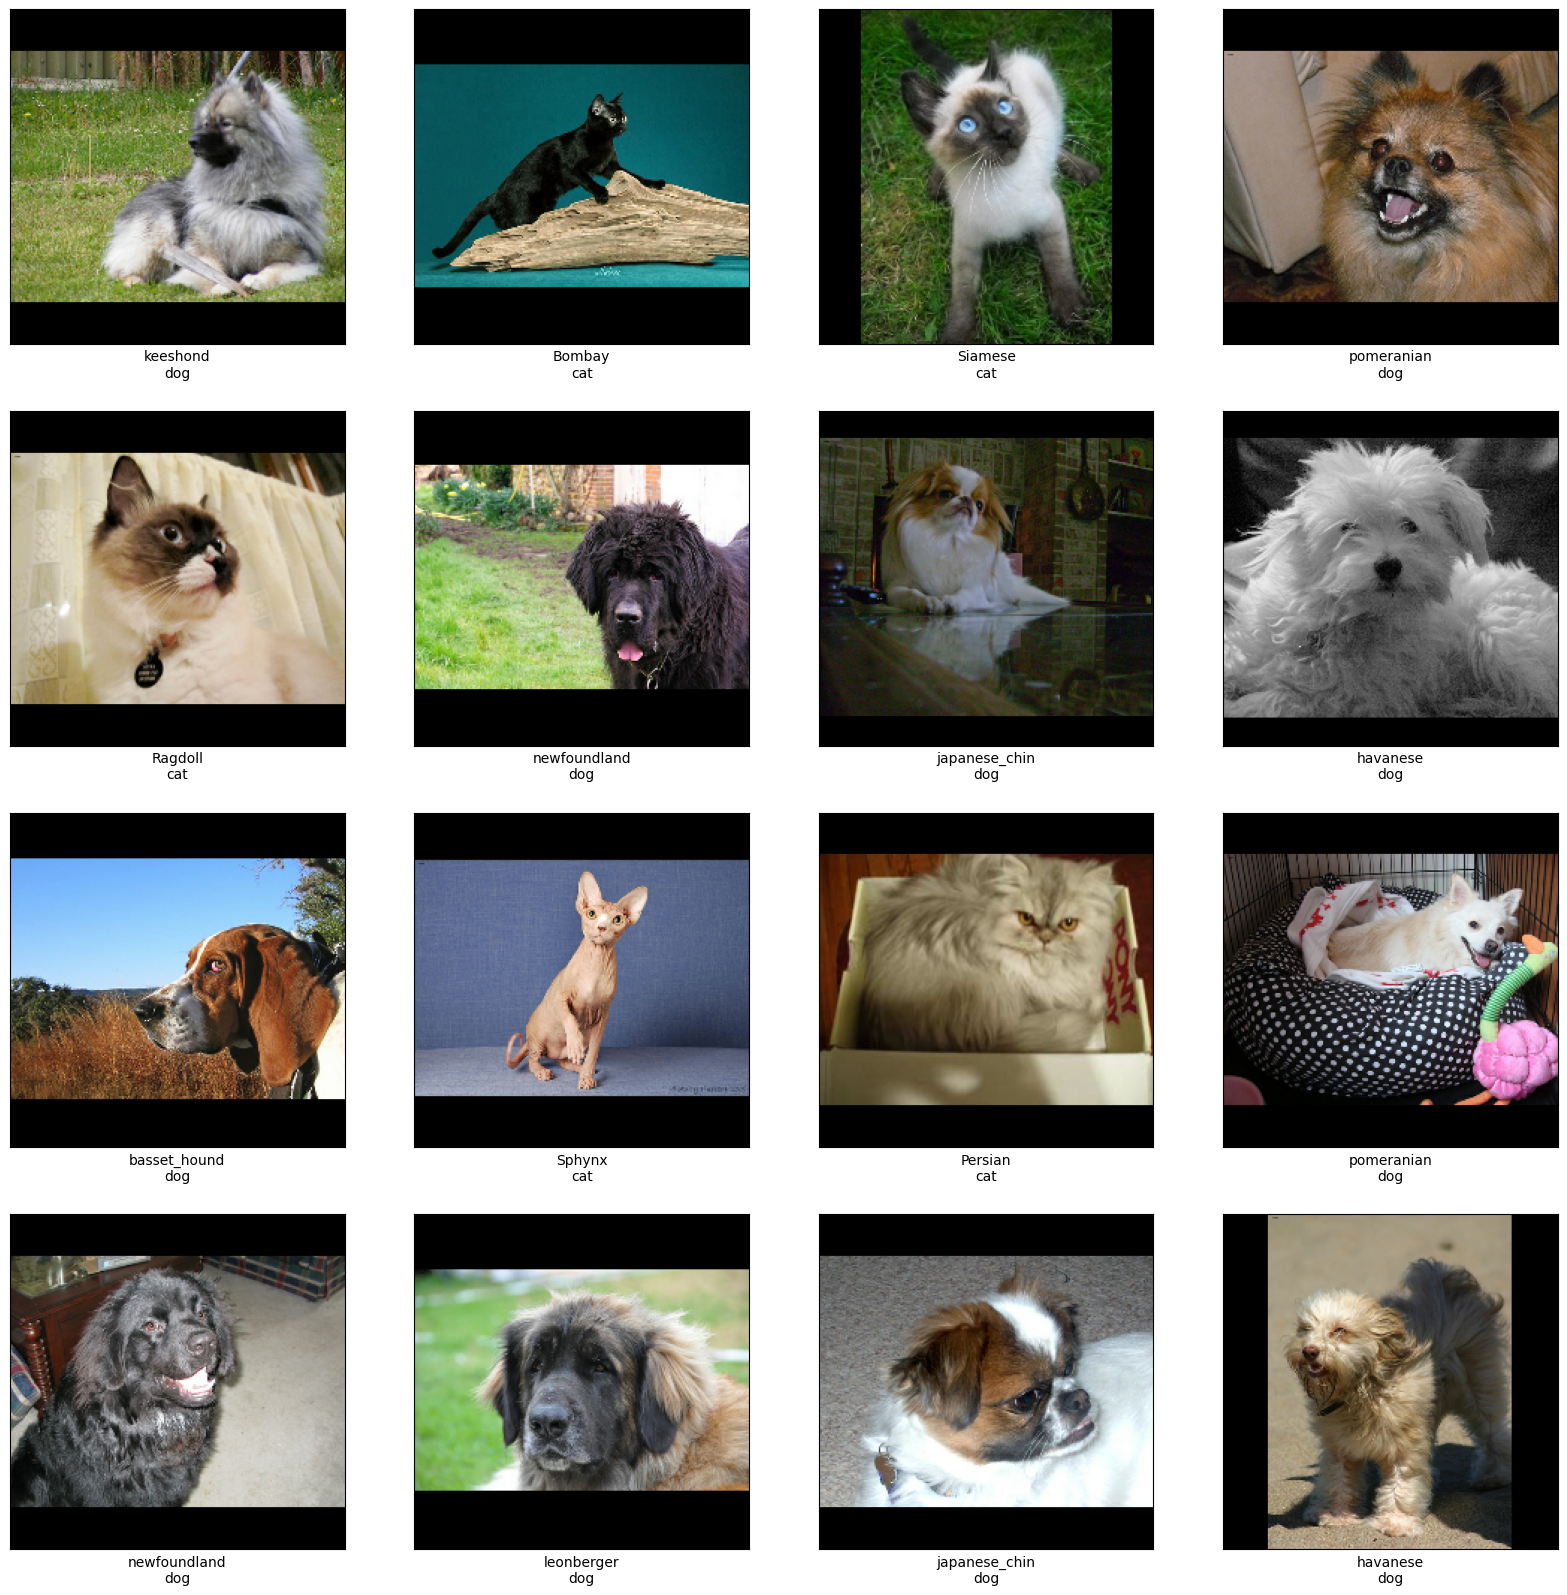

In [7]:
label = [
    "Abyssinian",
    "american_bulldog",
    "american_pit_bull_terrier",
    "basset_hound",
    "beagle",
    "Bengal",
    "Birman",
    "Bombay",
    "boxer",
    "British_Shorthair",
    "chihuahua",
    "Egyptian_Mau",
    "english_cocker_spaniel",
    "english_setter",
    "german_shorthaired",
    "great_pyrenees",
    "havanese",
    "japanese_chin",
    "keeshond",
    "leonberger",
    "Maine_Coon",
    "miniature_pinscher",
    "newfoundland",
    "Persian",
    "pomeranian",
    "pug",
    "Ragdoll",
    "Russian_Blue",
    "saint_bernard",
    "samoyed",
    "scottish_terrier",
    "shiba_inu",
    "Siamese",
    "Sphynx",
    "staffordshire_bull_terrier",
    "wheaten_terrier",
    "yorkshire_terrier",
]

plt.subplots(nrows = 4, ncols = 4, figsize = (20, 20))

for i, imgIndex in enumerate(np.random.randint(0, len(x_train), size = 16)):
    plt.subplot(4, 4, i + 1) 
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[imgIndex])
    breed = label[y_train[imgIndex]]
    species = "cat" if breed[0].isupper() == True else "dog"
    plt.xlabel(f'{breed}\n{species}')
plt.show()

Выше представлены изображения до нормализации. Размер изображений приведен к одному.

# Обучение модели

Для обучения была выбрана модель EfficientNetV2, так как обучается гораздо быстрее, чем современные модели, и при этом имеет в 6,8 раз меньший размер, а ее точность достигает 87,3%.

Инициализируем предобученный базовый слой модели, устанавливаем параметр `trainable=False`, что означает, что веса будут заморожены и не будут обновляться в процессе обучения.

* Используем Sequential для создания последовательных слоев
* Добавляем предобученный базовый слой
* Слой Flatten используется для преобразования многомерных данных в одномерный вектор перед подачей на полносвязные слои.
* Слои Dense с 128 и 64 нейронами и функцией активации 'relu' помогают в обучении нелинейных отображений между нейронами.
* Dropout используется для предотвращения переобучения, отключая случайные нейроны во время обучения.
* Слой Dense с 37 нейронами и функцией активации softmax используется для многоклассовой классификации (37 классов), и функция активации softmax преобразует выходы сети в вероятности принадлежности каждого класса.

In [9]:
pretrained_base = hub.KerasLayer(efficientnetv2_s, trainable=False)
model = keras.Sequential([
    pretrained_base,
    keras.layers.Flatten(),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64,activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(37, activation='softmax')
])
model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.fit(
    train_data,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH
)

Epoch 1/3


I0000 00:00:1715507142.048013     210 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


180/180 [==============================] - 63s 122ms/step - loss: 1.3246 - accuracy: 0.6438
Epoch 2/3
180/180 [==============================] - 22s 124ms/step - loss: 0.5397 - accuracy: 0.8399
Epoch 3/3
180/180 [==============================] - 22s 123ms/step - loss: 0.3868 - accuracy: 0.8793


В качестве метрики для оценки качества обучения была выбрана "accuracy", которая характеризует качество модели, агрегированное по всем классам. Она представляет собой простую и понятную метрику. Хорошо подходит для задач классификации, где необходимо знать долю правильно угаданных классов.

В результате оценки качества модели на тестовых данных модель смогла достичь точности 87%. 
Для улучшения качества модели можно по-другому настроить значения гиперпараметров, увеличить количество эпох для обучения, также использовать методы аугментации для обучения модели на разнообразных данных.

# Предсказанные значения сегментации:

1/1 [==============================] - 2s 2s/step


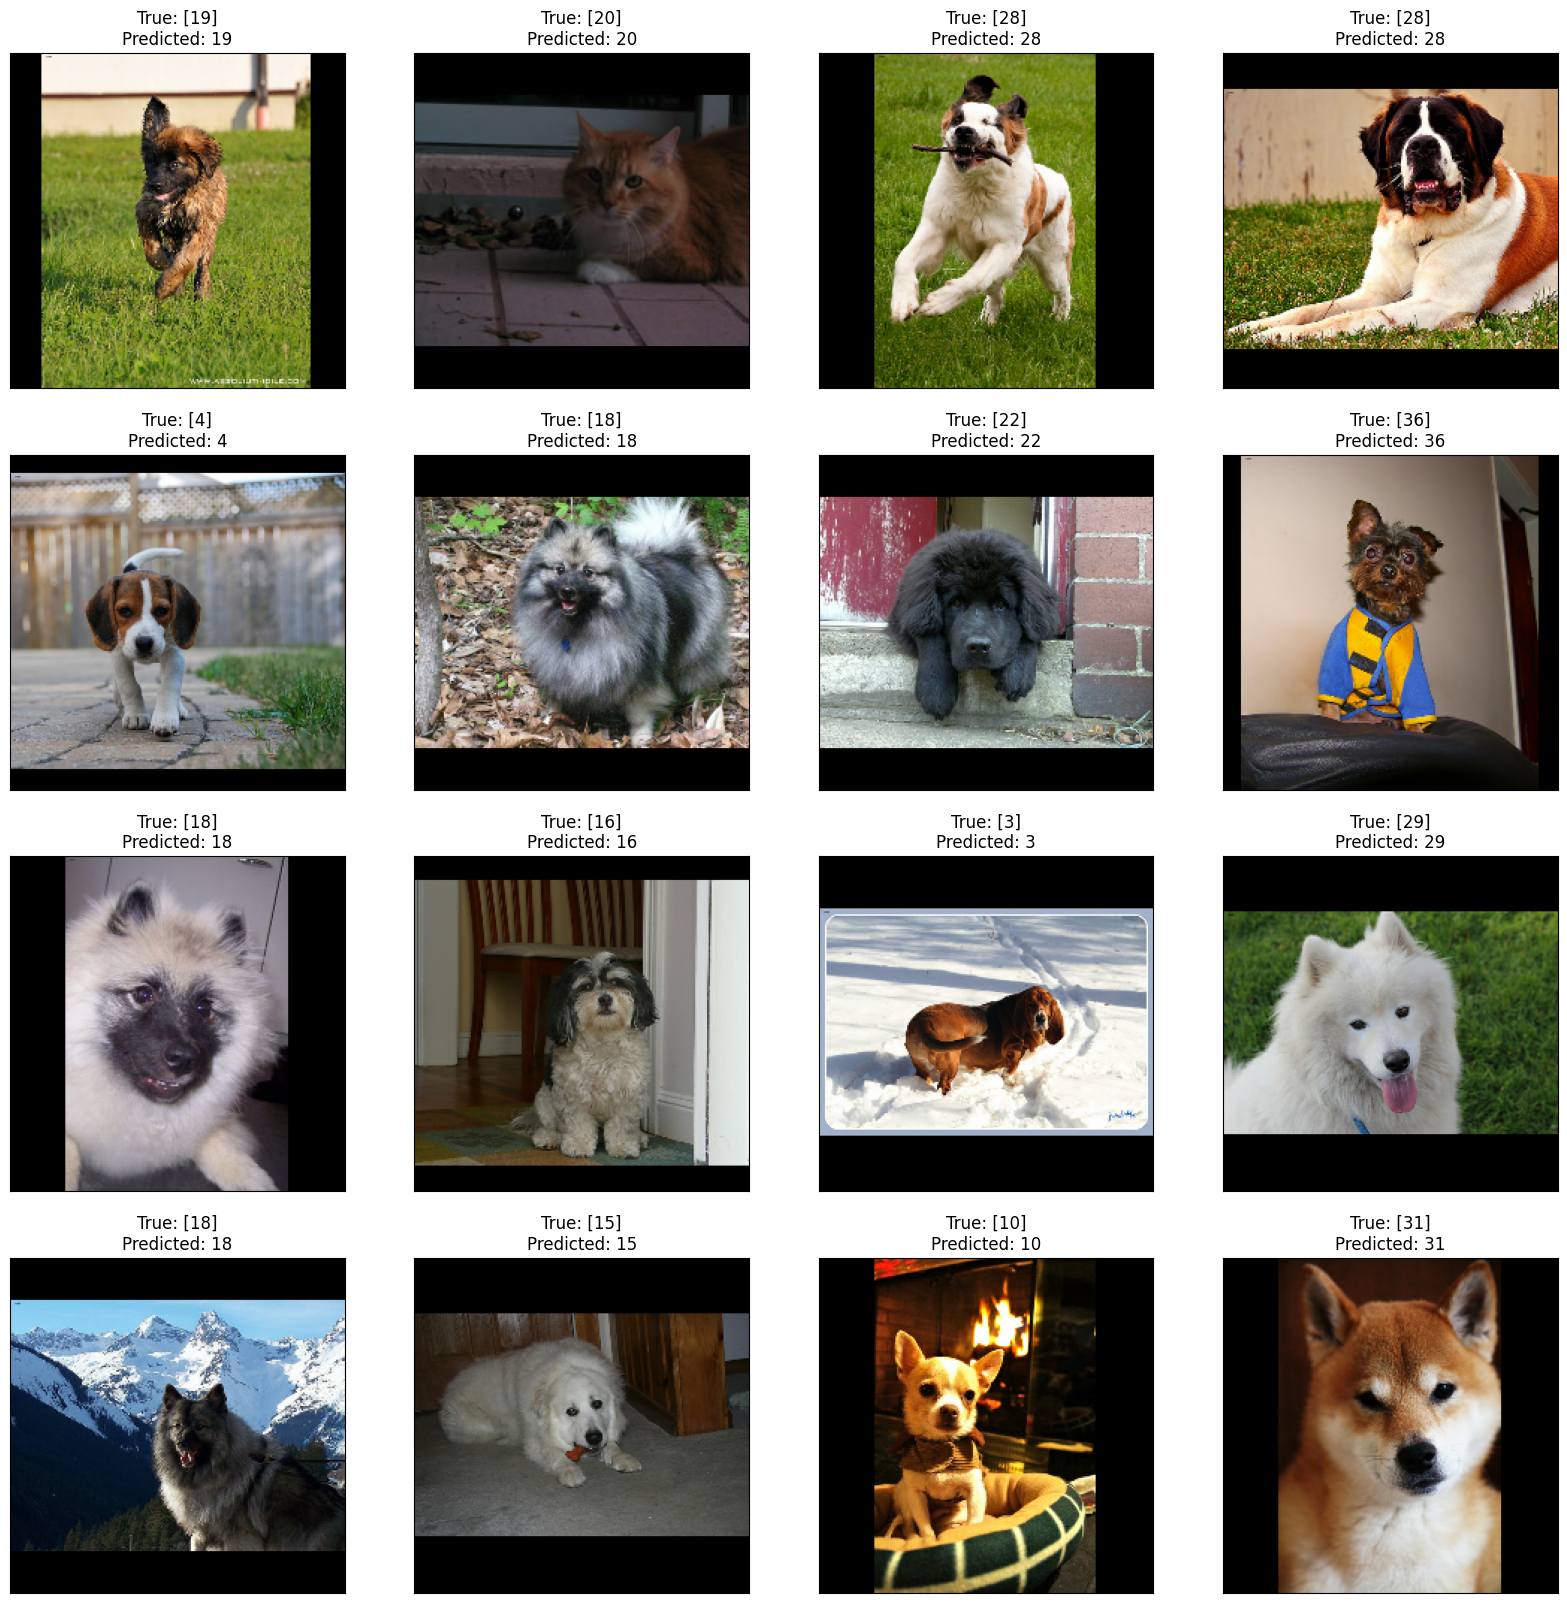

In [16]:
gen_data = next(test_data)

plt.subplots(nrows = 4, ncols = 4, figsize = (20, 20))
pred = model.predict(gen_data[0]).argmax(1)

for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(gen_data[0][i])
    
    if(pred.any()):
        plt.title(f"True: {[gen_data[1][i]]}\nPredicted: {pred[i]}")
    else:
        plt.title(gen_data[1][i])